In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Sat Feb  3 14:46:46 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        Off | 00000000:19:00.0 Off |                  Off |
|  0%   55C    P8              44W / 450W |     11MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Model Parts

In [3]:
from model.main.enc_prior_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.prior.uniform_prior import Prior
from model.latent.min_latent import Latent
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 4
hp.h_dims = [32, 64, 128, 256, 512]
hp.M = 1024
hp.N = 256
hp.z_activation = F.tanh

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 6.0202789306640625
encoder.convs 5.989013671875
encoder.linear 0.0312652587890625
prior 0.0
latent 0.0
decoder 6.059947967529297
decoder.linear 0.0390625
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train02.02-6/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, models, opt_g = load(save_dir, 0, models, optimizer)

total 0


### Dataset

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=hp.N, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

7.6%

100.0%


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100.0%


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100.0%


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100.0%

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

done


### Preprocess

In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


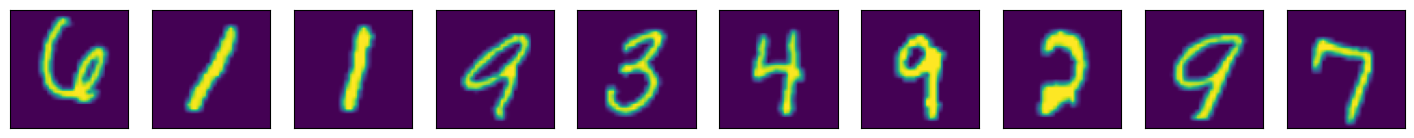

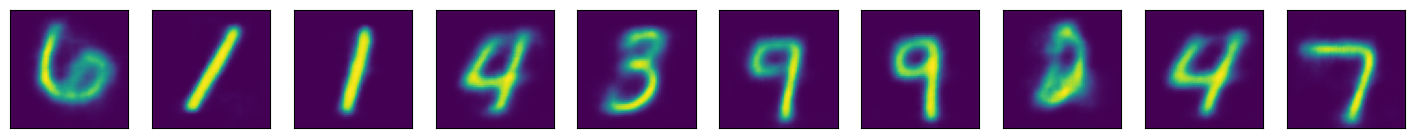

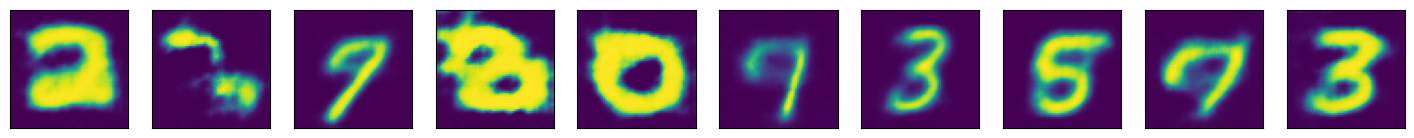

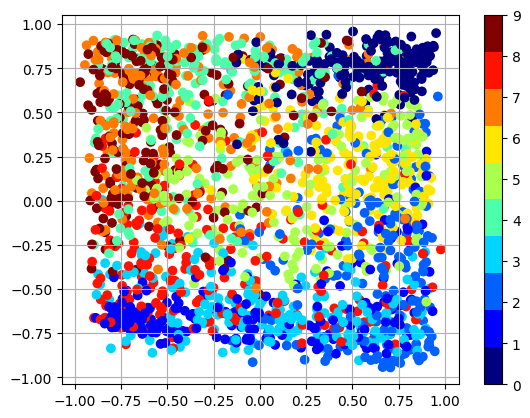

2001
lse_loss 0.11936754733324051
recon_loss 0.08880706876516342
2002
lse_loss 0.11333246529102325
recon_loss 0.08681925386190414
2003
lse_loss 0.12169692665338516
recon_loss 0.0911133885383606
2004
lse_loss 0.10914621502161026
recon_loss 0.09112438559532166
2005
lse_loss 0.11459939181804657
recon_loss 0.08824919164180756
2006
lse_loss 0.12280476093292236
recon_loss 0.08973613381385803
2007
lse_loss 0.11146187782287598
recon_loss 0.09096278995275497
2008
lse_loss 0.11344460397958755
recon_loss 0.09310658276081085
2009
lse_loss 0.11130288243293762
recon_loss 0.09930674731731415
2010
lse_loss 0.11230100691318512
recon_loss 0.08924194425344467
2011
lse_loss 0.11690501123666763
recon_loss 0.09337317943572998
2012
lse_loss 0.11960263550281525
recon_loss 0.09367087483406067
2013
lse_loss 0.1201629489660263
recon_loss 0.08941357582807541
2014
lse_loss 0.11430899053812027
recon_loss 0.09152309596538544
2015
lse_loss 0.11601082235574722
recon_loss 0.09250251948833466
2016
lse_loss 0.11674129962

2128
lse_loss 0.11934985220432281
recon_loss 0.09509021043777466
2129
lse_loss 0.11521267145872116
recon_loss 0.09647785127162933
2130
lse_loss 0.11577226966619492
recon_loss 0.09131255000829697
2131
lse_loss 0.1135871410369873
recon_loss 0.09129992127418518
2132
lse_loss 0.1196623370051384
recon_loss 0.0871797427535057
2133
lse_loss 0.11603618413209915
recon_loss 0.08985348045825958
2134
lse_loss 0.12059411406517029
recon_loss 0.08964010328054428
2135
lse_loss 0.11349692195653915
recon_loss 0.09484662860631943
2136
lse_loss 0.1184394359588623
recon_loss 0.09029006212949753
2137
lse_loss 0.1214664876461029
recon_loss 0.08935531973838806
2138
lse_loss 0.1155974417924881
recon_loss 0.09280582517385483
2139
lse_loss 0.11212765425443649
recon_loss 0.09559369087219238
2140
lse_loss 0.11127740889787674
recon_loss 0.08476146310567856
2141
lse_loss 0.11436567455530167
recon_loss 0.08817967772483826
2142
lse_loss 0.11686532944440842
recon_loss 0.09985387325286865
2143
lse_loss 0.112797006964683

2258
lse_loss 0.11438313126564026
recon_loss 0.08423642814159393
2259
lse_loss 0.12093770503997803
recon_loss 0.08994898200035095
2260
lse_loss 0.11874916404485703
recon_loss 0.09095429629087448
2261
lse_loss 0.11366637796163559
recon_loss 0.0948840007185936
2262
lse_loss 0.11847832798957825
recon_loss 0.09093712270259857
2263
lse_loss 0.11797107756137848
recon_loss 0.08813172578811646
2264
lse_loss 0.11685722321271896
recon_loss 0.083088219165802
2265
lse_loss 0.11665894091129303
recon_loss 0.09582748264074326
2266
lse_loss 0.11252978444099426
recon_loss 0.09123402833938599
2267
lse_loss 0.1169946938753128
recon_loss 0.09420397132635117
2268
lse_loss 0.11947382986545563
recon_loss 0.087604820728302
2269
lse_loss 0.11567683517932892
recon_loss 0.08801448345184326
2270
lse_loss 0.11617253720760345
recon_loss 0.09301449358463287
2271
lse_loss 0.11638157814741135
recon_loss 0.09126940369606018
2272
lse_loss 0.10860738158226013
recon_loss 0.0840001329779625
2273
lse_loss 0.1143216788768768

2388
lse_loss 0.11556123197078705
recon_loss 0.08337676525115967
2389
lse_loss 0.11795491725206375
recon_loss 0.08431850373744965
2390
lse_loss 0.11378500610589981
recon_loss 0.0900987833738327
2391
lse_loss 0.11586779356002808
recon_loss 0.09043078124523163
2392
lse_loss 0.11286074668169022
recon_loss 0.09126508235931396
2393
lse_loss 0.11163058876991272
recon_loss 0.085779570043087
2394
lse_loss 0.11410308629274368
recon_loss 0.08391769975423813
2395
lse_loss 0.12093590199947357
recon_loss 0.084306500852108
2396
lse_loss 0.11222183704376221
recon_loss 0.0882520079612732
2397
lse_loss 0.11709772795438766
recon_loss 0.08990229666233063
2398
lse_loss 0.11234799027442932
recon_loss 0.08050241321325302
2399
lse_loss 0.11930809915065765
recon_loss 0.09458670020103455
2400
lse_loss 0.11673810333013535
recon_loss 0.08210595697164536
2401
lse_loss 0.11891371756792068
recon_loss 0.08501635491847992
2402
lse_loss 0.11279930174350739
recon_loss 0.09854250401258469
2403
lse_loss 0.111573308706283

2515
lse_loss 0.11346647143363953
recon_loss 0.09522318094968796
2516
lse_loss 0.11499165743589401
recon_loss 0.08602087944746017
2517
lse_loss 0.11254878342151642
recon_loss 0.09091490507125854
2518
lse_loss 0.11166925728321075
recon_loss 0.08975853770971298
2519
lse_loss 0.11479995399713516
recon_loss 0.0852956622838974
2520
lse_loss 0.11713594198226929
recon_loss 0.09579771757125854
2521
lse_loss 0.11552727967500687
recon_loss 0.0886114239692688
2522
lse_loss 0.11787857115268707
recon_loss 0.08921583741903305
2523
lse_loss 0.11847040057182312
recon_loss 0.09403067827224731
2524
lse_loss 0.11557227373123169
recon_loss 0.08025650680065155
2525
lse_loss 0.12039981037378311
recon_loss 0.09957118332386017
2526
lse_loss 0.1125180572271347
recon_loss 0.09115125238895416
2527
lse_loss 0.11397211253643036
recon_loss 0.08912750333547592
2528
lse_loss 0.11530939489603043
recon_loss 0.08945010602474213
2529
lse_loss 0.11392492800951004
recon_loss 0.0831870585680008
2530
lse_loss 0.1185512766242

2645
lse_loss 0.11258867383003235
recon_loss 0.08943714946508408
2646
lse_loss 0.11698803305625916
recon_loss 0.0896991714835167
2647
lse_loss 0.11733747273683548
recon_loss 0.08193342387676239
2648
lse_loss 0.11075642704963684
recon_loss 0.09106843173503876
2649
lse_loss 0.12064874172210693
recon_loss 0.08776187151670456
2650
lse_loss 0.11338350176811218
recon_loss 0.0887497290968895
2651
lse_loss 0.11513465642929077
recon_loss 0.08709191530942917
2652
lse_loss 0.11285379528999329
recon_loss 0.08781584352254868
2653
lse_loss 0.11819325387477875
recon_loss 0.09493600577116013
2654
lse_loss 0.11790325492620468
recon_loss 0.0902162417769432
2655
lse_loss 0.1143244057893753
recon_loss 0.08829911798238754
2656
lse_loss 0.11158930510282516
recon_loss 0.09232126176357269
2657
lse_loss 0.1107243001461029
recon_loss 0.08240120857954025
2658
lse_loss 0.1128750815987587
recon_loss 0.08508491516113281
2659
lse_loss 0.11463254690170288
recon_loss 0.09314610809087753
2660
lse_loss 0.118557773530483

2775
lse_loss 0.1183934211730957
recon_loss 0.09115879237651825
2776
lse_loss 0.1127311959862709
recon_loss 0.089286208152771
2777
lse_loss 0.11584565043449402
recon_loss 0.0884229838848114
2778
lse_loss 0.11779698729515076
recon_loss 0.08502649515867233
2779
lse_loss 0.11700841039419174
recon_loss 0.09134082496166229
2780
lse_loss 0.1136656105518341
recon_loss 0.08369165658950806
2781
lse_loss 0.11432798951864243
recon_loss 0.0889945775270462
2782
lse_loss 0.11309891939163208
recon_loss 0.08850594609975815
2783
lse_loss 0.12076489627361298
recon_loss 0.08635609596967697
2784
lse_loss 0.11526690423488617
recon_loss 0.08594634383916855
2785
lse_loss 0.1190282329916954
recon_loss 0.08981263637542725
2786
lse_loss 0.11392338573932648
recon_loss 0.09125667810440063
2787
lse_loss 0.11328209936618805
recon_loss 0.08877583593130112
2788
lse_loss 0.11124929040670395
recon_loss 0.09381967782974243
2789
lse_loss 0.11526811122894287
recon_loss 0.08191506564617157
2790
lse_loss 0.12153694033622742

lse_loss 0.1213671937584877
recon_loss 0.08802103251218796
2904
lse_loss 0.11723659932613373
recon_loss 0.08537320792675018
2905
lse_loss 0.1149199903011322
recon_loss 0.08271609991788864
2906
lse_loss 0.11427514255046844
recon_loss 0.08969210088253021
2907
lse_loss 0.12139230966567993
recon_loss 0.08638615906238556
2908
lse_loss 0.11443129181861877
recon_loss 0.08568914979696274
2909
lse_loss 0.11538675427436829
recon_loss 0.086849644780159
2910
lse_loss 0.11367374658584595
recon_loss 0.0834718644618988
2911
lse_loss 0.11238101869821548
recon_loss 0.08623018115758896
2912
lse_loss 0.11545701324939728
recon_loss 0.08797549456357956
2913
lse_loss 0.11291579902172089
recon_loss 0.08733977377414703
2914
lse_loss 0.11480489373207092
recon_loss 0.08125361800193787
2915
lse_loss 0.11616714298725128
recon_loss 0.0870000422000885


KeyboardInterrupt: 

In [10]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, M=hp.M)

            # Backward
            loss = 0
            for key in data.keys():
                if 'kl_loss' in key:
                    loss = loss + data[key] * 0.00025
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
        
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model = model_list[0]
            model.eval()
            with torch.no_grad():
                data = model(data, M=hp.M)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = torch.randn(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
                
            import matplotlib.pyplot as plt
            _z = data['z'].data.cpu().numpy()
            plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
            plt.grid()
            plt.colorbar()
            plt.show()
        
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

In [ ]:
import matplotlib.pyplot as plt
display.clear_output()

batch = next(iter(test_loader))
data = preprocess(batch)

model = model_list[0]
model.eval()
with torch.no_grad():
    data = model(data, M=hp.M)

plot(data['x'])
plot(data['y'])

with torch.no_grad():
    z = torch.randn(10, hp.z_dim).to(device)
    y = model.sample(z)
    plot(y)
    
import matplotlib.pyplot as plt
_z = data['z'].data.cpu().numpy()
plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
plt.grid()
plt.colorbar()
plt.show()